# Notes on "A Lumped Parameter Model for Cardiac Output Estimation Using Arterial Blood Pressure Waveform"

Sahoo KP, Patra A, Ghosh N, Pal A, Sinha A, Khandelwal S. A Lumped
Parameter Model for Cardiac Output Estimation Using Arterial Blood Pressure
Waveform. In: 2021 43rd Annual International Conference of the IEEE Engineering
in Medicine & Biology Society (EMBC). IEEE; 2021:5523-5526.
doi:10.1109/EMBC46164.2021.9629803

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

## Valve equation

$$ R_\mathrm{valve}(\Delta P_\mathrm{valve}; R_\mathrm{op}, R_\mathrm{cl}) =
    R_\mathrm{cl} - \frac{R_\mathrm{cl} - R_\mathrm{op}
    }{1 + \mathrm{exp}(-20 \cdot \Delta P_\mathrm{valve})}.$$

$$ R_\mathrm{mv}(p_\mathrm{sv}, p_\mathrm{lv}) \equiv
    R_\mathrm{valve}(p_\mathrm{sv} - p_\mathrm{lv}; R_\mathrm{op,mv}, R_\mathrm{cl}) $$

$$ R_\mathrm{av}(p_\mathrm{lv}, p_\mathrm{sa}) \equiv
    R_\mathrm{valve}(p_\mathrm{lv} - p_\mathrm{sa}; R_\mathrm{op,av}, R_\mathrm{cl}) $$

In [2]:
def R_valve(dP, Rop, Rcl):
    return Rcl - (Rcl - Rop) / (1 + np.exp(np.minimum(100, np.maximum(-100, -20 * dP))))

def R_mv(p_sv, p_lv_, R_mv_op, R_cl):
    return R_valve(p_sv - p_lv_, R_mv_op, R_cl)
                   
def R_av(p_lv_, p_sa, R_av_op, R_cl):
    return R_valve(p_lv_ - p_sa, R_av_op, R_cl)

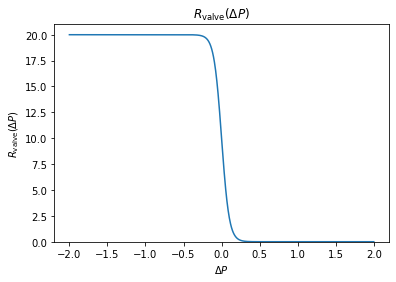

In [3]:
dP = np.linspace(-2, 2, 1000)
plt.plot(dP, R_valve(dP, 0.007, 20))
plt.title("$R_\mathrm{valve}(\Delta P)$")
plt.xlabel("$\Delta P$")
plt.ylabel("$R_\mathrm{valve}(\Delta P)$")
plt.ylim(0,21)
del dP

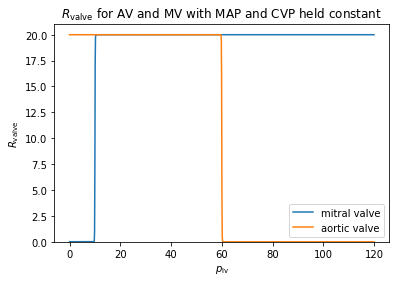

In [4]:
p_lv_ = np.linspace(0, 120, 1000)
plt.plot(p_lv_, R_mv(10, p_lv_, 0.007, 20), label="mitral valve")
plt.plot(p_lv_, R_av(p_lv_, 60, 0.001, 20), label="aortic valve")
plt.title("$R_\mathrm{valve}$ for AV and MV with MAP and CVP held constant")
plt.xlabel("$p_\mathrm{lv}$")
plt.ylabel("$R_\mathrm{valve}$")
plt.legend()
plt.ylim(0,21)
del p_lv_

## Ventricular elastance equation

$$g(t; t_1, t_2) = 
\left\{ \begin{array}{ll}
        \frac{1}{2}\left(1 - \mathrm{cos}\left(\frac{t}{t_1}\pi\right)\right)
        & \hbox{if } 0 \leq t < t_1, \\
        \frac{1}{2}\left(1 + \mathrm{cos}\left(\frac{t - t_1}{t_2 - t_1}\pi\right)\right)
        & \hbox{if } t_1 \leq t < t_2, \\
        0 & \hbox{otherwise.}
\end{array}\right.$$

$$E_\mathrm{lv}(t) = E_\mathrm{min} + (E_\mathrm{max} - E_\mathrm{min})
    \ g(\mathrm{mod}(t, T), T_M, T_M + T_r).$$
    
$$p_\mathrm{lv}(t, V_\mathrm{lv}) = E_\mathrm{lv}(t)(V_\mathrm{lv} - V_d)$$

In [5]:
def pulse(t, t_1, t_2):
    return (
        (0 <= t) * (t < t_1) * (1 - np.cos(t / t_1 * np.pi))/2 +
        (t_1 <= t) * (t < t_2) * (1 + np.cos((t - t_1) / (t_2 - t_1) * np.pi))/2
    )

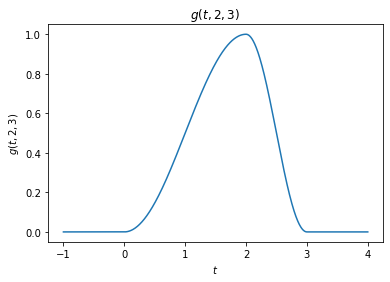

In [6]:
t = np.linspace(-1, 4, 1000)
plt.plot(t, pulse(t, 2, 3))
plt.title("$g(t, 2, 3)$")
plt.xlabel("$t$")
plt.ylabel("$g(t, 2, 3)$")
del t

In [7]:
def E_lv(t, E_min, E_max, T_M, T_r, T):
    return E_min + (E_max - E_min) * pulse(t % T, T_M, T_M + T_r)

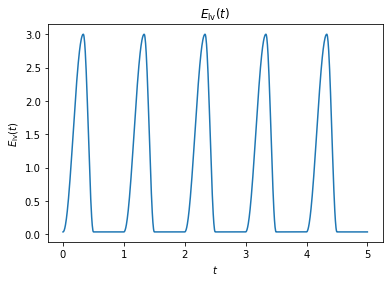

In [8]:
t = np.linspace(0, 5, 1000)
plt.plot(t, E_lv(t, 4/110, 3, 1/3., 1/6., 1))
plt.title("$E_\mathrm{lv}(t)$")
plt.xlabel("$t$")
plt.ylabel("$E_\mathrm{lv}(t)$")
del t

In [9]:
def p_lv(t, V_lv, V_d, E_min, E_max, T_M, T_r, T):
    return E_lv(t, E_min, E_max, T_M, T_r, T) * (V_lv - V_d)

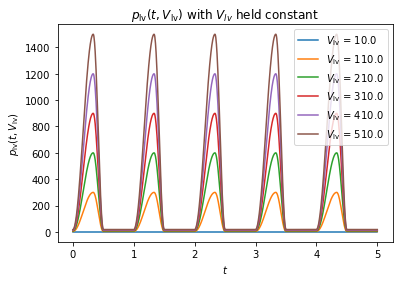

In [10]:
t = np.linspace(0, 5, 1000)
V_lv = np.linspace(10, 510, 6)
V_lv_grid, t_grid = np.meshgrid(V_lv, t)
plt.plot(t_grid, p_lv(t_grid, V_lv_grid, 10, 4/110, 3, 1/3., 1/6., 1),
        label=[f"$V_\mathrm{{lv}}$ = {v}" for v in V_lv])
plt.title("$p_\mathrm{lv}(t, V_\mathrm{lv})$ with $V_{lv}$ held constant")
plt.xlabel("$t$")
plt.ylabel("$p_\mathrm{lv}(t, V_\mathrm{lv})$")
plt.legend()
del t
del V_lv
del t_grid
del V_lv_grid

# Equations of state:

$$\begin{array}{rll}
\frac{dV_\mathrm{lv}}{dt} &=& 
    \frac{p_\mathrm{sv} - p_\mathrm{lv}(t, V_\mathrm{lv})}{
        R_\mathrm{mv}(p_\mathrm{sv}, p_\mathrm{lv}(t, V_\mathrm{lv}))}
    - \frac{p_\mathrm{lv}(t, V_\mathrm{lv}) - p_\mathrm{sa}}{
        R_\mathrm{av}(p_\mathrm{lv}(t, V_\mathrm{lv}), p_\mathrm{sa})} \\
\frac{dp_\mathrm{sa}}{dt} &=& \frac{1}{C_\mathrm{sa1}}\left(
    \frac{p_\mathrm{lv}(t, V_\mathrm{lv}) - p_\mathrm{sa}}{
        R_\mathrm{av}(p_\mathrm{lv}(t, V_\mathrm{lv}), p_\mathrm{sa})}
    - \frac{p_\mathrm{sa} - p_\mathrm{sv}}{R_\mathrm{s1}}
    - q_a
    \right) \\
\frac{dp_\mathrm{sa2}}{dt} &=& \frac{1}{C_\mathrm{sa2}}\left(
    q_a
    - \frac{p_\mathrm{sa2} - p_\mathrm{sv}}{R_\mathrm{s2}}
    \right) \\
\frac{dp_\mathrm{sv}}{dt} &=& \frac{1}{C_\mathrm{sv}}\left(
    \frac{p_\mathrm{sa} - p_\mathrm{sv}}{R_\mathrm{s1}}
    + \frac{p_\mathrm{sa2} - p_\mathrm{sv}}{R_\mathrm{s2}}
    - \frac{p_\mathrm{sv} - p_\mathrm{lv}(t, V_\mathrm{lv})}{
        R_\mathrm{mv}(p_\mathrm{sv}, p_\mathrm{lv}(t, V_\mathrm{lv}))}
    \right) \\
\frac{dq_a}{dt} &=& \frac{1}{L_a}\left(
    p_\mathrm{sa} - p_\mathrm{sa2} - R_a q_a
    \right)
\end{array}$$

In [11]:
def dV_lv(p_sa, p_sv, p_lv_, R_mv_, R_av_):
    return (p_sv - p_lv_)/R_mv_ - (p_lv_ - p_sa)/R_av_

In [12]:
def dp_sa(p_sa, p_sv, q_a, p_lv_, R_av_, C_sa1, R_s1):
    return 1/C_sa1 * (
        (p_lv_ - p_sa) / R_av_ - (p_sa - p_sv) / R_s1 - q_a
    )

In [13]:
def dp_sa2(p_sa2, p_sv, q_a, C_sa2, R_s2):
    return 1/C_sa2 * (q_a - (p_sa2 - p_sv) / R_s2)

In [14]:
def dp_sv(p_sa, p_sa2, p_sv, p_lv_, R_mv_, C_sv, R_s1, R_s2):
    return 1/C_sv * (
        (p_sa - p_sv) / R_s1 + (p_sa2 - p_sv) / R_s2
        - (p_sv - p_lv_) / R_mv_
    )

In [15]:
def dq_a(p_sa, p_sa2, q_a, L_a, R_a):
    return 1/L_a * (p_sa - p_sa2 - R_a * q_a)

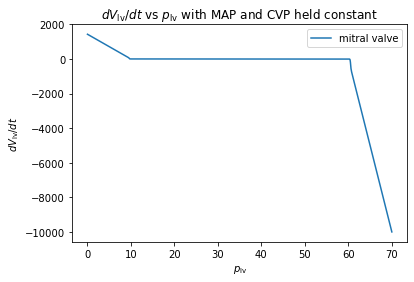

In [16]:
p_lv_ = np.linspace(0, 70, 1000)
R_mv_ = R_mv(10, p_lv_, 0.007, 20)
R_av_ = R_av(p_lv_, 60, 0.001, 20)
plt.plot(p_lv_, dV_lv(60, 10, p_lv_, R_mv_, R_av_), label="mitral valve")
plt.title("$dV_\mathrm{lv}/dt$ vs $p_\mathrm{lv}$ with MAP and CVP held constant")
plt.xlabel("$p_\mathrm{lv}$")
plt.ylabel("$dV_\mathrm{lv}/dt$")
plt.legend()
del p_lv_
del R_mv_
del R_av_

In [17]:
# define indexes for the state variables in the state vector
sv_p_sa = 0
sv_p_sa2 = 1
sv_p_sv = 2
sv_V_lv = 3
sv_q_a = 4

In [18]:
initial_values = np.zeros(shape=(5,))

initial_values[sv_p_sa] = 70 # rough guess
initial_values[sv_p_sa2] = 70 * 0.95 # rough guess
initial_values[sv_p_sv] = 3.5
initial_values[sv_V_lv] = 60
initial_values[sv_q_a] = 0.9 * 70 # rough guess

In [19]:
params = dict(
    E_max = 140 / (50 - 10), # rough guess from plot
    E_min = 4 / (120 - 10),
    T_r = 0.1, # rough guess from plot
    T_M = 0.2,  # rough guess from plot
    T = 1, # rouch guess from plot
    V_d = 10,
    R_cl = 20,
    R_mv_op = 0.007,
    R_av_op = 0.001,
    R_s2 = (initial_values[sv_p_sa2] - initial_values[sv_p_sv]) /
        initial_values[sv_q_a],
    C_sa1 = (0.25 * 0.03 * 60*70) / initial_values[sv_p_sa], # guess
    C_sa2 = (0.19 * 0.1 * 60*70) / initial_values[sv_p_sa2], # guess
    C_sv = (0.05 * 0.72 * 60*70) / initial_values[sv_p_sv], # guess
    R_a = 0.10, # guess, range 0.04 to 0.12 for class I tracing
    L_a = 0.0045,
    R_s1 = 9 * (0.09 + (initial_values[sv_p_sa2] - initial_values[sv_p_sv]) /
        initial_values[sv_q_a]), # guess
)

In [20]:
def create_vectorized_dy_dt(*, E_max, E_min, T_r, T_M, T, V_d, 
                              R_cl, R_mv_op, R_av_op, R_s2,
                              C_sa1, C_sa2, C_sv, R_a, L_a, R_s1):
    def dy_dt(t, y):
        result = np.empty_like(y)
        p_sa, p_sa2, p_sv, V_lv, q_a = y
        p_lv_ = p_lv(t, V_lv, V_d, E_min, E_max, T_M, T_r, T)
        R_mv_ = R_mv(p_sv, p_lv_, R_mv_op, R_cl)
        R_av_ = R_av(p_lv_, p_sa, R_av_op, R_cl)
        
        result[sv_p_sa] = dp_sa(p_sa, p_sv, q_a, p_lv_, R_av_, C_sa1, R_s1)
        result[sv_p_sa2] = dp_sa2(p_sa2, p_sv, q_a, C_sa2, R_s2)
        result[sv_p_sv] = dp_sv(p_sa, p_sa2, p_sv, p_lv_, R_mv_, C_sv, R_s1, R_s2)
        result[sv_V_lv] = dV_lv(p_sa, p_sv, p_lv_, R_mv_, R_av_)
        result[sv_q_a] = dq_a(p_sa, p_sa2, q_a, L_a, R_a)
        
        return result
    
    return dy_dt

In [21]:
y_0 = initial_values
dy_dt = create_vectorized_dy_dt(**params)

In [22]:
result = integrate.solve_ivp(dy_dt, (0, 10), y_0, vectorized=True, method='BDF')

Text(0.5, 0, 'time (s)')

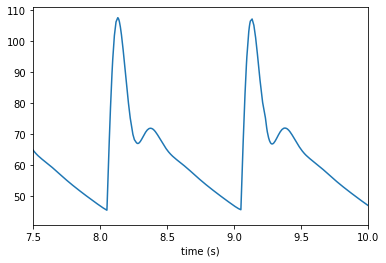

In [23]:
plt.plot(result['t'], result['y'][sv_p_sa])
plt.xlim(7.5, 10)
plt.xlabel('time (s)')